In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import pandas as pd
import xarray as xr

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If available, print the name of the GPU
if cuda_available:
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Device count: {torch.cuda.device_count()}")

DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

class SeaIceDataset(Dataset):
    def __init__(self, data_directory, configuration, split_array, start_prediction_months, \
                split_type='train', target_shape=(336, 320)):
        self.data_directory = data_directory
        self.configuration = configuration
        self.split_array = split_array
        self.start_prediction_months = start_prediction_months
        self.split_type = split_type
        self.target_shape = target_shape

        # Open the HDF5 files
        self.inputs_file = h5py.File(f"{data_directory}/inputs_{configuration}.h5", 'r')
        self.targets_file = h5py.File(f"{data_directory}/targets.h5", 'r')
        
        self.inputs = self.inputs_file[f"inputs_{configuration}"]
        self.targets = self.targets_file['targets_sea_ice_only']

        self.n_samples, self.n_channels, self.n_y, self.n_x = self.inputs.shape
        
        # Get indices for the specified split type
        self.indices = np.where(self.split_array == split_type)[0]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        input_data = self.inputs[actual_idx]
        target_data = self.targets[actual_idx]
        start_prediction_month = self.start_prediction_months[actual_idx]

        # Pad input_data and target_data to the target shape
        pad_y = self.target_shape[0] - self.n_y
        pad_x = self.target_shape[1] - self.n_x
        input_data = np.pad(input_data, ((0, 0), (0, pad_y), (0, pad_x)), mode='constant', constant_values=0)
        target_data = np.pad(target_data, ((0, 0), (0, pad_y), (0, pad_x)), mode='constant', constant_values=0)

        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        target_tensor = torch.tensor(target_data, dtype=torch.float32)

        # Get the target months for this sample
        target_months = pd.date_range(start=start_prediction_month, end=start_prediction_month + pd.DateOffset(months=5), freq="MS")
        target_months = target_months.month.to_numpy()
        
        return input_tensor, target_tensor, target_months

    def __del__(self):
        self.inputs_file.close()
        self.targets_file.close()

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_filters_factor=1, filter_size=3):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(in_channels, int(64 * n_filters_factor), filter_size)
        self.encoder2 = self.conv_block(int(64 * n_filters_factor), int(128 * n_filters_factor), filter_size)
        self.encoder3 = self.conv_block(int(128 * n_filters_factor), int(256 * n_filters_factor), filter_size)
        self.bottleneck = self.conv_block(int(256 * n_filters_factor), int(512 * n_filters_factor), filter_size)
        
        self.decoder1 = self.conv_block(int(512 * n_filters_factor) + int(256 * n_filters_factor), int(256 * n_filters_factor), filter_size)
        self.decoder2 = self.conv_block(int(256 * n_filters_factor) + int(128 * n_filters_factor), int(128 * n_filters_factor), filter_size)
        self.decoder3 = self.conv_block(int(128 * n_filters_factor) + int(64 * n_filters_factor), int(64 * n_filters_factor), filter_size)
        
        self.final_conv = nn.Conv2d(int(64 * n_filters_factor), out_channels, kernel_size=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        
    def conv_block(self, in_channels, out_channels, filter_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, padding=filter_size//2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=filter_size, padding=filter_size//2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        bottleneck = self.bottleneck(self.pool(enc3))
        
        dec1 = self.upsample(bottleneck)
        dec1 = torch.cat((enc3, dec1), dim=1)
        dec1 = self.decoder1(dec1)
        
        dec2 = self.upsample(dec1)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec3 = self.upsample(dec2)
        dec3 = torch.cat((enc1, dec3), dim=1)
        dec3 = self.decoder3(dec3)
        
        return torch.sigmoid(self.final_conv(dec3))

class MaskedMSELoss(nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()
        self.ice_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/monthly_ice_mask.nc").mask

    def forward(self, outputs, targets, target_months):
        n_active_cells = 0

        for target_months_subset in target_months:
            n_active_cells += self.ice_mask.sel(month=target_months_subset.cpu()).sum().values
        
        loss = torch.sum((targets - outputs) ** 2) / n_active_cells
        
        return loss


TRAIN_MONTHS = pd.date_range(start='1981-01-01', end='2014-12-01', freq='MS')
VAL_MONTHS = pd.date_range(start='2015-01-01', end='2018-12-01', freq='MS')
TEST_MONTHS = pd.date_range(start='2019-01-01', end='2024-06-01', freq='MS')

# Construct the date range for the data pairs 
# Note that this is not continuous due to the missing data in 1987-1988 
first_range = pd.date_range('1981-01', pd.Timestamp('1987-12') - pd.DateOffset(months=6+1), freq='MS')
second_range = pd.date_range(pd.Timestamp('1988-01') + pd.DateOffset(months=12+1), '2024-01', freq='MS')
start_prediction_months = first_range.append(second_range)

split_array = np.empty(np.shape(start_prediction_months), dtype=object)
for i,month in enumerate(start_prediction_months):
    if month in TRAIN_MONTHS: split_array[i] = "train"
    if month in VAL_MONTHS: split_array[i] = "val"
    if month in TEST_MONTHS: split_array[i] = "test"

def print_split_stats(split_array):
    ntrain = sum(split_array == 'train')
    nval = sum(split_array == 'val')
    ntest = sum(split_array == 'test')
    
    print(f"train samples: {ntrain} ({round(ntrain / len(split_array), 2)}) \n \
    val samples: {nval} ({round(nval / len(split_array), 2)}) \n \
    test samples: {ntest} ({round(ntest / len(split_array), 2)})")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=23, out_channels=6, n_filters_factor=1, filter_size=3).to(device)

criterion = MaskedMSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print_split_stats(split_array)

model_configs={
    "name": "unet_resolution3",
    "lr": "1e-4", 
    "optimizer": "adam"
}

CUDA available: True
Device name: Tesla V100-PCIE-32GB
Device count: 1
train samples: 388 (0.78) 
     val samples: 48 (0.1) 
     test samples: 61 (0.12)


In [3]:
data_directory = os.path.join(DATA_DIRECTORY, 'sicpred/data_pairs_npy')
configuration = 'simple'
batch_size = 20

# Create dataset instances for training, validation, and testing
train_dataset = SeaIceDataset(data_directory, configuration, split_array, start_prediction_months, split_type='train', target_shape=(336, 320))
val_dataset = SeaIceDataset(data_directory, configuration, split_array, start_prediction_months, split_type='val', target_shape=(336, 320))
test_dataset = SeaIceDataset(data_directory, configuration, split_array, start_prediction_months, split_type='test', target_shape=(336, 320))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)


In [3]:
num_epochs = 80

train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets, target_months in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets, target_months)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, target_months in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets, target_months)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")

# Testing loop (optional)
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets, target_months in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets, target_months)
        test_loss += loss.item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

# Save the trained model
os.makedirs(f"{DATA_DIRECTORY}/sicpred/models", exist_ok=True)
model_full_name = f"{model_configs['name']}_{configuration}_lr{model_configs['lr']}_epoch{num_epochs}_{model_configs['optimizer']}"
torch.save(model.state_dict(), f"{DATA_DIRECTORY}/sicpred/models/{model_full_name}.pth")


Epoch [1/80], Loss: 0.4920
Validation Loss: 0.6009
Epoch [2/80], Loss: 0.3659
Validation Loss: 0.3497
Epoch [3/80], Loss: 0.3261
Validation Loss: 0.2856
Epoch [4/80], Loss: 0.3005
Validation Loss: 0.2756
Epoch [5/80], Loss: 0.2802
Validation Loss: 0.2659
Epoch [6/80], Loss: 0.2664
Validation Loss: 0.2557
Epoch [7/80], Loss: 0.2510
Validation Loss: 0.2498
Epoch [8/80], Loss: 0.2355
Validation Loss: 0.2397
Epoch [9/80], Loss: 0.2242
Validation Loss: 0.2266
Epoch [10/80], Loss: 0.2120
Validation Loss: 0.2214
Epoch [11/80], Loss: 0.1998
Validation Loss: 0.2004
Epoch [12/80], Loss: 0.1908
Validation Loss: 0.1940
Epoch [13/80], Loss: 0.1802
Validation Loss: 0.1955
Epoch [14/80], Loss: 0.1698
Validation Loss: 0.1842
Epoch [15/80], Loss: 0.1613
Validation Loss: 0.1742
Epoch [16/80], Loss: 0.1551
Validation Loss: 0.1606
Epoch [17/80], Loss: 0.1491
Validation Loss: 0.1571
Epoch [18/80], Loss: 0.1391
Validation Loss: 0.1439
Epoch [19/80], Loss: 0.1326
Validation Loss: 0.1474
Epoch [20/80], Loss: 

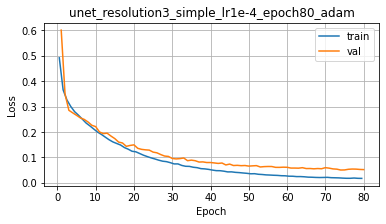

In [5]:

plt.figure(figsize=(6,3))
plt.plot(np.arange(0.5, 80.5, 1), train_losses, label="train")
plt.plot(np.arange(1, 81, 1), val_losses, label="val")
plt.legend()
plt.title(model_full_name)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

plt.savefig(f"../figures/{model_full_name}_training_curve", bbox_inches='tight', dpi=300)



In [6]:
from torchsummary import summary
summary(model, input_size=(23, 336, 320))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 336, 320]          13,312
              ReLU-2         [-1, 64, 336, 320]               0
            Conv2d-3         [-1, 64, 336, 320]          36,928
              ReLU-4         [-1, 64, 336, 320]               0
       BatchNorm2d-5         [-1, 64, 336, 320]             128
         MaxPool2d-6         [-1, 64, 168, 160]               0
            Conv2d-7        [-1, 128, 168, 160]          73,856
              ReLU-8        [-1, 128, 168, 160]               0
            Conv2d-9        [-1, 128, 168, 160]         147,584
             ReLU-10        [-1, 128, 168, 160]               0
      BatchNorm2d-11        [-1, 128, 168, 160]             256
        MaxPool2d-12          [-1, 128, 84, 80]               0
           Conv2d-13          [-1, 256, 84, 80]         295,168
             ReLU-14          [-1, 256,

In [4]:
model_full_name = f"{model_configs['name']}_{configuration}_lr{model_configs['lr']}_epoch80_{model_configs['optimizer']}"

model_state_path = os.path.join(f"{DATA_DIRECTORY}/sicpred/models/{model_full_name}.pth")

model.load_state_dict(torch.load(model_state_path, map_location=device))

model.eval()
test_loss = 0.0
inputs_list = []
outputs_list = []
targets_list = []

with torch.no_grad():
    for inputs, targets, target_months in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        inputs_list.append(inputs)
        outputs_list.append(outputs)
        targets_list.append(targets)
        loss = criterion(outputs, targets, target_months)
        print(loss.item() * inputs.size(0))


0.8730316162109375
0.9119126200675964
1.6244728863239288
0.07869317382574081


In [5]:
nsdic_sic = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc")


/home/users/yucli/sicpred_env/lib64/python3.6/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'siconc' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/home/users/yucli/sicpred_env/lib64/python3.6/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'nsidc_bt_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/home/users/yucli/sicpred_env/lib64/python3.6/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'nsidc_nt_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/home/users/yucli/sicpred_env/lib64/python3.6/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'qa_of_cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_

Text(0.5, 0.98, 'Prediction for 12/2022 at 1 lead month')

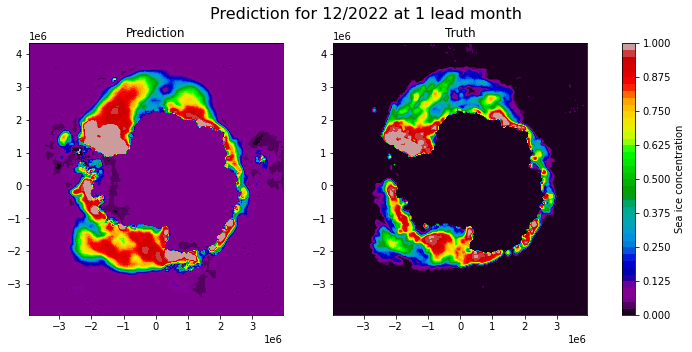

In [8]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

month_index = 7
lead_time = 0
list_elem = 2

ax1.contourf(nsdic_sic.xgrid, nsdic_sic.ygrid, outputs_list[list_elem][month_index,lead_time,2:334,2:318].cpu(), cmap='nipy_spectral',\
    levels=np.arange(0,1.025,0.025))
cax = ax2.contourf(nsdic_sic.xgrid, nsdic_sic.ygrid, targets_list[list_elem][month_index,lead_time,2:334,2:318].cpu(), cmap='nipy_spectral',\
    levels=np.arange(0,1.025,0.025))

ax1.set_title("Prediction")
ax2.set_title("Truth")

cbar = fig.colorbar(cax, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('Sea ice concentration')

predicted_month = TEST_MONTHS[month_index + lead_time + list_elem*batch_size]

plt.suptitle(f"Prediction for {predicted_month.month:02}/{predicted_month.year} at {lead_time+1} lead month", fontsize=16)
#plt.savefig(f"../figures/{model_full_name}_{predicted_month.month:02}_{predicted_month.year}_lead_{lead_time+1}.jpg", dpi=300, bbox_inches='tight')

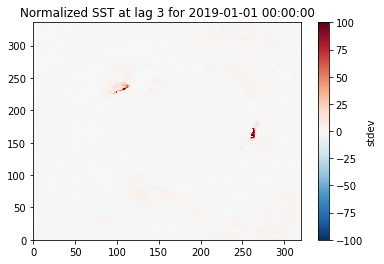

In [26]:
month_index = 0
list_elem = 0

predicted_month = TEST_MONTHS[month_index + list_elem*batch_size]

plt.pcolormesh(inputs_list[list_elem][month_index,20,:,:].cpu(), vmin=-100, vmax=100, cmap="RdBu_r")
plt.title(f"Normalized SST at lag 3 for {predicted_month}")
plt.colorbar(label='stdev')
plt.savefig("../figures/known_issues/large_normalized_sst_at_ice_edge.jpg", dpi=300, bbox_inches='tight')


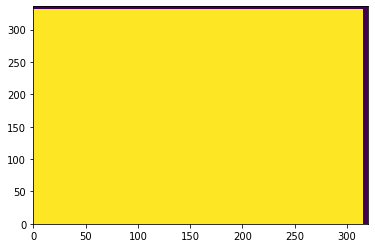

In [28]:
plt.pcolormesh(inputs_list[list_elem][month_index,22,:,:].cpu())
